In [1]:
# # dependencies
%matplotlib inline
from matplotlib import style
style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine , func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [4]:
# create engine to hawaii.sqlite 
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model 
# declare a Base using automap_base
Base = automap_base()

In [6]:
# use the Base class to reflect the database tables 
#Base.prepare(engine, reflect=True)
Base.prepare(autoload_with=engine)

In [7]:
# print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Assign the measurment class to a variable Measurment
Measurement = Base.classes.measurement

In [9]:
# Assign the station class to a variable Station
Station = Base.classes.station

In [10]:
#Create session (LINK) from Python to the DB
session = Session(engine)

# Investigte the DB

In [11]:
from sqlalchemy import inspect

In [12]:
# create the inspector and connect it to the engin
inspector = inspect(engine)

In [13]:
# collect the names of the tables within the DB
inspector.get_table_names()

['measurement', 'station']

In [14]:
# using the intospector to pint the column names within the measurement table and its type
columns =inspector.get_columns("measurement")
for column in columns:
    primarykeystr = ""
    if column["primary_key"] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [15]:
# using the intospector to pint the column names within the station table and its type
columns =inspector.get_columns("station")
for column in columns:
    primarykeystr = ""
    if column["primary_key"] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Precipitation Analysis

In [16]:
#total dates
session.query(func.count(Measurement.date)).all()

[(19550,)]

In [17]:
# FIND THE MOST RESENT DATA IN THE DB 
# the date is in the measurement table, lets see the earliest and latest date 
# Earliest DATE
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01',)

In [18]:
# Latest DATE 
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores

prcp_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>="2016-08-23")\
                                                            .filter(Measurement.date<="2017-08-23").all()


In [20]:
# Save the query results as a Pandas DataFrame
prcp_df = pd.DataFrame(prcp_data, columns=["date", "precipitation"])

# Set the date column as the dataframe index
prcp_df.set_index("date", inplace=True)

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)
prcp_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


In [21]:
# Drop rows with NaN values
prcp_df.dropna(inplace=True)
prcp_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


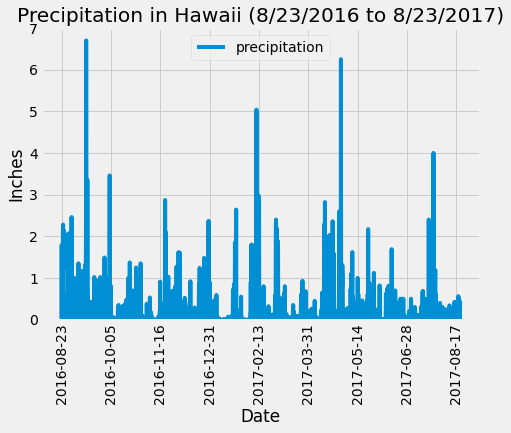

In [22]:
prcp_plot = prcp_df.plot(figsize=(7,5), ylim=(0,7), rot=90)
prcp_plot.set_ylabel("Inches")
prcp_plot.set_xlabel("Date")
plt.title("Precipitation in Hawaii (8/23/2016 to 8/23/2017)")
prcp_plot.grid(True)
#plt.savefig("Images/precipitation_bar.png")
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data

#summary_stats = prcp_df.describe()
#print(summary_stats)

prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#  Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.id).count() 
print(f"There are {station_count} totla stations in this dateset.")

There are 9 totla stations in this dateset.


In [25]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and observation counts in descending order.

most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                                    .group_by(Measurement.station)\
                                    .order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_number = 'USC00519281'
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.round(func.avg(Measurement.tobs), 2)).filter(Measurement.station == station_number).all()

[(54.0, 85.0, 71.66)]

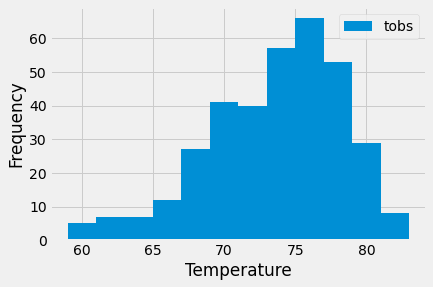

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
station_highest_obs = most_active_stations[0][0]

results = session.query(Measurement.date, Measurement.tobs)\
                        .filter(Measurement.date >= "2016-08-23")\
                        .filter(Measurement.date <= "2017-08-23")\
                        .filter(Measurement.station == station_highest_obs).all()

# convert to dataframe
results_df = pd.DataFrame(results)

#plot the results as a histogram
ax = results_df.plot.hist(bins=12)
ax.set_xlabel("Temperature")

# show the plot
plt.show()

In [29]:
# Close Session
session.close()